In [1]:
%matplotlib inline
import os
import re
import io

import matplotlib
import numpy as np
import pandas as pd
import xarray as xr

import climatools.html.html as climahtml
import climatools.lblnew.g1_threshold as scripts

import IPython.display as display

import imp
imp.reload(scripts)

/chia_cluster/home/jackyu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)
/chia_cluster/home/jackyu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'climatools.lblnew.g1_threshold' from '/chia_cluster/home/jackyu/climatools/climatools/lblnew/g1_threshold.py'>

In [2]:
%run param.py

In [3]:
NG_REFS = PARAM['ng_refs']
P_REFS, T_REFS = zip(*PARAM['ref_pts'])

In [4]:
# for printing some input parameters

def innames():
    return ['vstar', 'nband', 'nv', 'dv',
            'flgh2o',
            'tsfc',
            'pressure_reference_1',
            'temperature_reference_1', 
            'pressure_reference_2', 
            'temperature_reference_2',
            'ighigh', 
            'ng', 
            'nref',
            'p_refs',
            't_refs',
            'ng_refs',
            'ng_adju',
            'absth',
            'wgt',
            'option_wgt_flux',
            'option_wgt_k',
            'option_klin',
            'w_diffuse',
            'fac_meank',
            'klin',
            'option_compute_ktable',
            'option_compute_btable',
            'conc']



def pattern_assign(name):
    return ''' 
    parameter .* :: \s* &? \s* ({} \s* = .* \n)
    '''.format(name)

def pattern_data(name):
    return '''
    (data [^/{name}]+ {name}[^,] [^/{name}]+ / [^/]+ /)
    '''.format(name=name)

def pattern_atmpro():
    return '''
    (atmosphere_profiles/.*75_r8.pro)
    '''
    

def get_input_params(code, names):
    results = []
    for name in names:
        regex = re.compile(pattern_assign(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
        regex = re.compile(pattern_data(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
    regex = re.compile(pattern_atmpro(), re.VERBOSE)
    results.extend(regex.findall(code))
        
    results = [result.replace('_r8', '') for result in results]
    return results


In [5]:
analysis = scripts.Analysis()

In [6]:
crd = analysis.model('crd')
crd.type_model = 'crd'
crd.rundir = DIR_FORTRAN
crd.fpath_flux = 'output_fluxg.dat'
crd.fpath_coolr = 'output_coolrg.dat'
crd.linestyle = '-'
crd.color = 'b'
crd.marker = None
crd.load_data()

In [7]:
def add_wgt_models():
    iggs = [10, 1]
    markers = [None, 'x']
    colors = ['r', 'c']
    linestyle = '-'

    df_wfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                         'output_wfluxg.dat'), 
                            sep=r'\s+')

    df_wcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wcoolrg.dat'), 
                             sep=r'\s+')

    for igg, marker, color in zip(iggs, markers, colors):

        flux_igg = df_wfluxg[df_wfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wcoolrg[df_wcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdx_igg = analysis.model('wgt_igg{}'.format(igg))
        crdx_igg.type_model = 'crd'
        crdx_igg.rundir = DIR_FORTRAN
        crdx_igg.fpath_flux = s_flux
        crdx_igg.fpath_coolr = s_coolr
        crdx_igg.color = color
        crdx_igg.marker = marker
        crdx_igg.linestyle = linestyle
        crdx_igg.load_data()
        
add_wgt_models()

In [8]:
def add_ktable_models():
    iggs = [10]
    markers = ['D',]
    color = 'g'
    linestyle = ':'

    df_wwfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wwfluxg.dat'), 
                             sep=r'\s+')

    df_wwcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                           'output_wwcoolrg.dat'), 
                              sep=r'\s+')

    for igg, marker in zip(iggs, markers):

        flux_igg = df_wwfluxg[df_wwfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wwcoolrg[df_wwcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdxx_igg = analysis.model('ktable_igg{}'.format(igg))
        crdxx_igg.type_model = 'crd'
        crdxx_igg.rundir = DIR_FORTRAN
        crdxx_igg.fpath_flux = s_flux
        crdxx_igg.fpath_coolr = s_coolr
        crdxx_igg.color = color
        crdxx_igg.marker = marker
        crdxx_igg.linestyle = linestyle
        crdxx_igg.load_data()
        
        

In [9]:
fig = analysis.fig_fluxcoolr('fig1', vartypes=['cooling rate'])
fig.ggroups = list(crd.data['dgdgs'].coords['g'].values) #list(range(1, 8 + 1))
fig.vars_plot['flux'] = ['flug', 'fnetg']
fig.vars_plot['cooling rate'] = ['coolrg']
fig.colors['flug'] = 'darkred'
fig.colors['fnetg'] = 'lightcoral'
fig.colors['coolrg'] = 'blue'
fig.varlims_from_indexrange['linear'] = (50, 1050)
fig.varlims_from_indexrange['log'] = (1e-2, 200)

fig.set_pressure_displayrange(low=1e-2)

In [10]:
table_fluxg = analysis.table('table_fluxg')
table_fluxg.sumg = False
table_fluxg.vartype = 'flux'
table_fluxg.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolrg = analysis.table('table_coolrg')
table_coolrg.vartype = 'cooling rate'
table_coolrg.sumg = False
table_coolrg.at_pressures = crd.data['cooling rate']\
                               .coords['pressure']\
                               .isel(pressure=[0, -1])


In [11]:
table_flux = analysis.table('table_flux')
table_flux.sumg = True
table_flux.vartype = 'flux'
table_flux.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolr = analysis.table('table_coolr')
table_coolr.vartype = 'cooling rate'
table_coolr.sumg = True
table_coolr.at_pressures = crd.data['cooling rate']\
                              .coords['pressure']\
                              .isel(pressure=[0, -1])

In [12]:
table_dgdgs = analysis.table('dgdgs')
table_dgdgs.vartype = 'dgdgs'
table_dgdgs.sumg = False

In [13]:
for name, value in sorted(PARAM.items()):
    print('{} = {}'.format(name, value))

atmpro = saw
band = 7
commitnumber = a22ab94
conc = 6.4e-07
dv = 0.01
klin = 2.22e-20
molecule = n2o
ng_adju = [0]
ng_refs = [5]
nv = 100
option_compute_btable = 0
option_compute_ktable = 0
option_wgt_flux = 1
option_wgt_k = 1
ref_pts = [(50, 250)]
tsfc = 257
vmax = 1380
vmin = 1215
w_diffuse = [(1.66, 1.66, 1.66, 1.66, 1.66)]
wgt = [(0.6, 0.7, 0.7, 0.8, 1)]


In [14]:
fig.display_hrefanchor()

In [15]:
table_fluxg.display_hrefanchor()
table_coolrg.display_hrefanchor()

table_flux.display_hrefanchor()
table_coolr.display_hrefanchor()

In [16]:
table_dgdgs.display_hrefanchor()

In [17]:
s_abscom = 'Overall absth'
display.HTML(climahtml.getHTML_hrefanchor(s_abscom))

In [18]:
s_ggroup_summary = 'g-group summary'
display.HTML(climahtml.getHTML_hrefanchor(s_ggroup_summary))

In [19]:
#for g in range(1, 20 + 1):
#    s = 'Table: cooling rate. g-group {}'.format(g)
#    html = climahtml.getHTML_hrefanchor(s)
#    display.display(display.HTML(html))

# Figure: cooling rate g-group 1

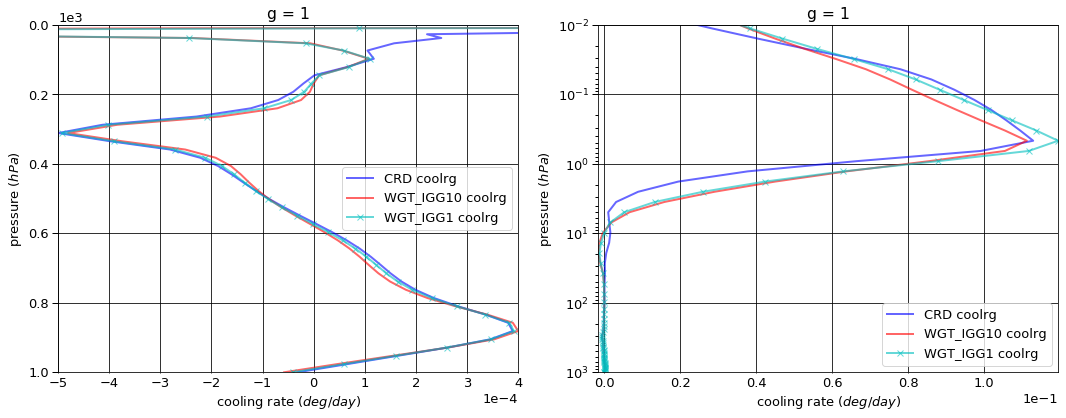

# Figure: cooling rate g-group 2

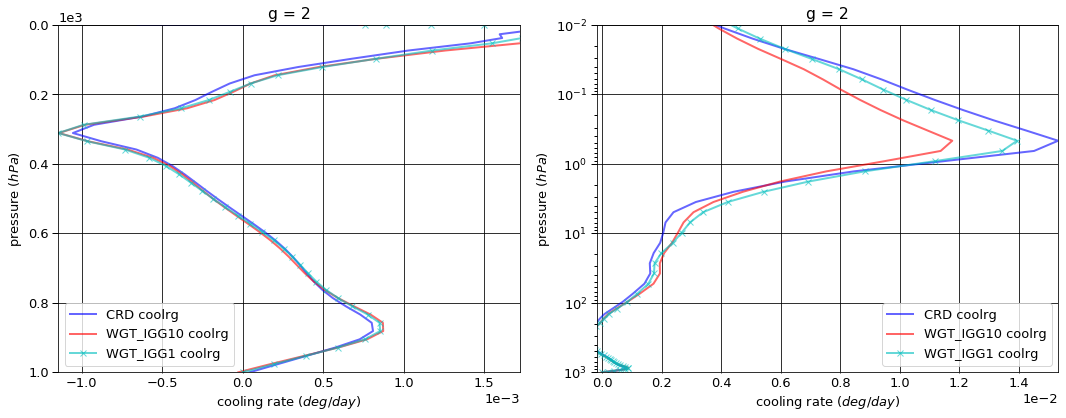

# Figure: cooling rate g-group 3

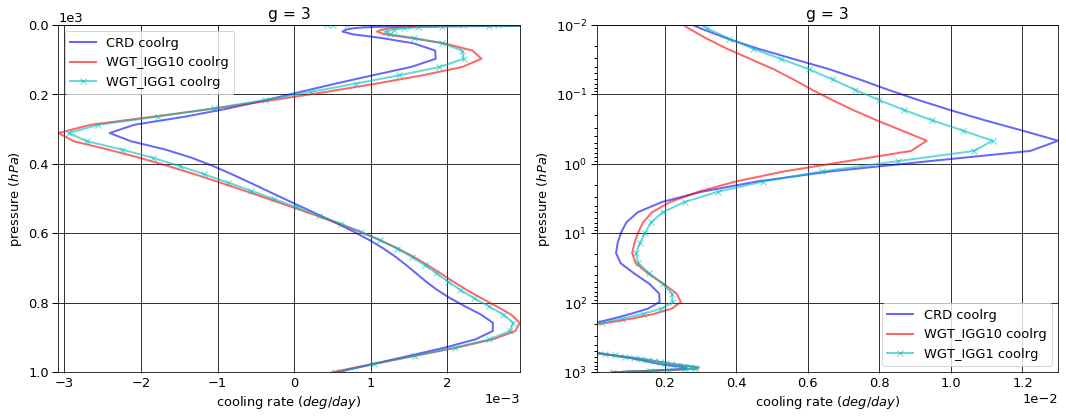

# Figure: cooling rate g-group 4

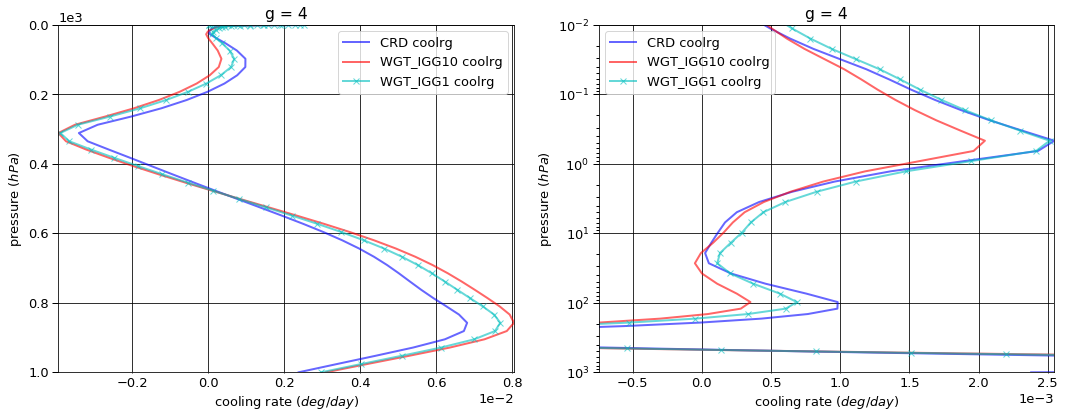

# Figure: cooling rate g-group 5

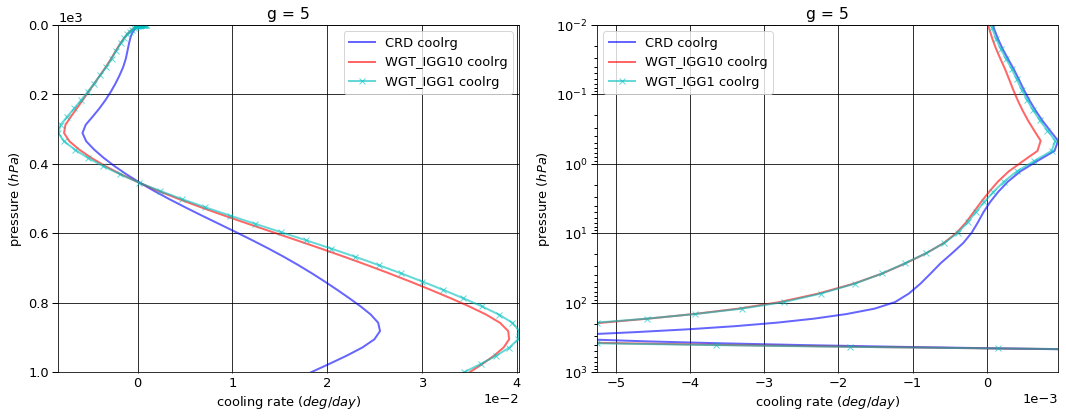

# Figure: cooling rate g-group total

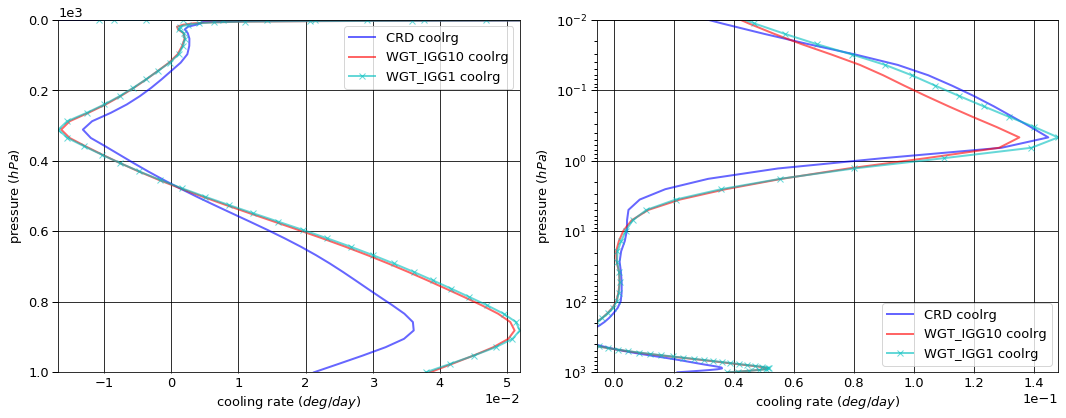

In [20]:
matplotlib.rcParams.update({'font.size': 13,
                            'grid.color': 'black',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 

fig.plot(analysis)


In [21]:
table_fluxg.display_withdiff(analysis, benchmark='crd')
table_coolrg.display_withdiff(analysis, benchmark='crd')
table_flux.display_withdiff(analysis, benchmark='crd')
table_coolr.display_withdiff(analysis, benchmark='crd')

# Table: flux. g-groups 


CRD


flug      fldg     fnetg
g pressure level                              
1 0.0      1     -0.020510  0.000000 -0.020510
  1013.0   76    -0.048368  0.049129  0.000761
2 0.0      1     -0.027149  0.000000 -0.027149
  1013.0   76    -0.100161  0.096432 -0.003730
3 0.0      1     -0.108586  0.000000 -0.108586
  1013.0   76    -0.300883  0.266991 -0.033893
4 0.0      1     -0.364113  0.000000 -0.364113
  1013.0   76    -0.717684  0.579612 -0.138071
5 0.0      1     -7.783572  0.000000 -7.783572
  1013.0   76    -8.390934  1.540714 -6.850220


WGT_IGG10


flug      fldg     fnetg
g pressure level                              
1 0.0      1     -0.022890  0.000000 -0.022890
  1013.0   76    -0.048409  0.049736  0.001328
2 0.0      1     -0.025420  0.000000 -0.025420
  1013.0   76    -0.100269  0.102389  0.002120
3 0.0      1     -0.083923  0.000000 -0.083923
  1013.0   76    -0.301082  0.298428 -0.002654
4 0.0      1     -0.320527  0.000000 -0.320527
  1013.0   76    -0.718282  0.653141 -0.065142
5 0.0      1     -7.681232  0.000000 -7.681232
  1013.0   76    -8.389988  2.124889 -6.265099


WGT_IGG1


flug      fldg     fnetg
g pressure level                              
1 0.0      1     -0.023069  0.000000 -0.023069
  1013.0   76    -0.048409  0.049463  0.001055
2 0.0      1     -0.025777  0.000000 -0.025777
  1013.0   76    -0.100269  0.101440  0.001171
3 0.0      1     -0.087795  0.000000 -0.087795
  1013.0   76    -0.301082  0.293035 -0.008047
4 0.0      1     -0.332656  0.000000 -0.332656
  1013.0   76    -0.718282  0.633365 -0.084917
5 0.0      1     -7.604499  0.000000 -7.604499
  1013.0   76    -8.389988  2.245134 -6.144854


WGT_IGG10 - CRD


flug      fldg     fnetg
g pressure level                              
1 0.0      1     -0.002380  0.000000 -0.002380
  1013.0   76    -0.000040  0.000607  0.000567
2 0.0      1      0.001729  0.000000  0.001729
  1013.0   76    -0.000108  0.005957  0.005849
3 0.0      1      0.024663  0.000000  0.024663
  1013.0   76    -0.000199  0.031437  0.031238
4 0.0      1      0.043587  0.000000  0.043587
  1013.0   76    -0.000599  0.073528  0.072930
5 0.0      1      0.102340  0.000000  0.102340
  1013.0   76     0.000946  0.584175  0.585121


WGT_IGG1 - CRD


flug      fldg     fnetg
g pressure level                              
1 0.0      1     -0.002560  0.000000 -0.002560
  1013.0   76    -0.000040  0.000334  0.000294
2 0.0      1      0.001372  0.000000  0.001372
  1013.0   76    -0.000108  0.005008  0.004900
3 0.0      1      0.020791  0.000000  0.020791
  1013.0   76    -0.000199  0.026044  0.025845
4 0.0      1      0.031458  0.000000  0.031458
  1013.0   76    -0.000599  0.053753  0.053154
5 0.0      1      0.179073  0.000000  0.179073
  1013.0   76     0.000946  0.704421  0.705366

# Table: cooling rate. g-groups 


CRD


coolrg
g pressure    layer          
1 0.000312    1     -0.047193
  1001.112500 75    -0.000032
2 0.000312    1     -0.000652
  1001.112500 75     0.000044
3 0.000312    1     -0.000265
  1001.112500 75     0.000559
4 0.000312    1     -0.000182
  1001.112500 75     0.002380
5 0.000312    1     -0.000120
  1001.112500 75     0.018302


WGT_IGG10


coolrg
g pressure    layer          
1 0.000312    1     -0.004022
  1001.112500 75    -0.000058
2 0.000312    1      0.000726
  1001.112500 75    -0.000027
3 0.000312    1      0.000356
  1001.112500 75     0.000492
4 0.000312    1     -0.000021
  1001.112500 75     0.003101
5 0.000312    1     -0.000139
  1001.112500 75     0.035040


WGT_IGG1


coolrg
g pressure    layer          
1 0.000312    1     -0.011885
  1001.112500 75    -0.000041
2 0.000312    1      0.000760
  1001.112500 75     0.000002
3 0.000312    1      0.000425
  1001.112500 75     0.000535
4 0.000312    1      0.000014
  1001.112500 75     0.002974
5 0.000312    1     -0.000141
  1001.112500 75     0.034452


WGT_IGG10 - CRD


coolrg
g pressure    layer          
1 0.000312    1      0.043171
  1001.112500 75    -0.000026
2 0.000312    1      0.001378
  1001.112500 75    -0.000071
3 0.000312    1      0.000621
  1001.112500 75    -0.000067
4 0.000312    1      0.000162
  1001.112500 75     0.000720
5 0.000312    1     -0.000019
  1001.112500 75     0.016738


WGT_IGG1 - CRD


coolrg
g pressure    layer          
1 0.000312    1      0.035308
  1001.112500 75    -0.000010
2 0.000312    1      0.001412
  1001.112500 75    -0.000042
3 0.000312    1      0.000690
  1001.112500 75    -0.000024
4 0.000312    1      0.000196
  1001.112500 75     0.000594
5 0.000312    1     -0.000021
  1001.112500 75     0.016150

# Table: flux. g-groups total


CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-8.30393,0.000000,-8.303930
1013.0,76,-9.55803,2.532877,-7.025153



WGT_IGG10


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-8.133992,0.000000,-8.133992
1013.0,76,-9.558030,3.228582,-6.329448



WGT_IGG1


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-8.073796,0.000000,-8.073796
1013.0,76,-9.558030,3.322437,-6.235593



WGT_IGG10 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,1.699383e-01,0.000000,0.169938
1013.0,76,1.400000e-08,0.695705,0.695705



WGT_IGG1 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,2.301339e-01,0.00000,0.230134
1013.0,76,1.400000e-08,0.78956,0.789560


# Table: cooling rate. g-groups total


CRD


,,coolrg
pressure,layer,
0.000312,1,-0.048412
1001.112500,75,0.021253



WGT_IGG10


,,coolrg
pressure,layer,
0.000312,1,-0.003099
1001.112500,75,0.038548



WGT_IGG1


,,coolrg
pressure,layer,
0.000312,1,-0.010827
1001.112500,75,0.037921



WGT_IGG10 - CRD


,,coolrg
pressure,layer,
0.000312,1,0.045313
1001.112500,75,0.017295



WGT_IGG1 - CRD


,,coolrg
pressure,layer,
0.000312,1,0.037585
1001.112500,75,0.016668


In [22]:
table_dgdgs.display_dgdgs(crd)

# Table: dgdgs. g-groups 

,dg,dgs
g,,
1,0.004909,0.005065
2,0.010121,0.010491
3,0.030667,0.031500
4,0.072909,0.075150
5,0.881394,0.877795


In [23]:
# read and display overall absth
display.display(
    display.HTML(climahtml.getHTML_idanchor(s_abscom)))
display.display(
    display.Markdown(climahtml.getMarkdown_sectitle(s_abscom)))

display.display(pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'),
                sep=r'\s+',
                index_col=[0]))

# Overall absth

,abscom
g,
1,2.772903e-18
2,5.547231e-19
3,1.109731e-19
4,2.220033e-20
5,2.176729e-27


In [24]:
def spreadsheet(ng_refs, p_refs):
    ng = crd.data['dgdgs'].dims['g']
    
    df_abscom = pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'), 
                            sep=r'\s+', index_col=[0])
    
    # absth(g + 1) / absth(g)
    df_abscom_copy = df_abscom.copy()
    df_abscom_copy.index = df_abscom.index + 1
    df_absratio = df_abscom / df_abscom_copy
    df_absratio.columns = ['k(ig) / k(ig - 1)']
    df_absratio = df_absratio.loc[: ng]
    df_dgdgs = crd.data['dgdgs'].to_dataframe()
    
    
    df_dgdgs_cumsum = df_dgdgs.cumsum(axis=0)
    df_dgdgs_cumsum.columns = ['dg cumsum', 'dgs cumsum']
    
    data_pref = np.concatenate([p_ref * np.ones((ng_ref,)) 
                                for ng_ref, p_ref 
                                in zip(ng_refs, p_refs)], axis=0)
    df_pref = pd.DataFrame(data_pref, 
                           index=df_dgdgs.index, columns=['pref'])
    
    df_all = pd.concat([df_abscom, df_absratio,
                        df_dgdgs, df_dgdgs_cumsum,
                        df_pref], axis=1) 
    return df_all
    

In [25]:
display.display(display.HTML(climahtml.getHTML_idanchor(s_ggroup_summary)))
display.display(display.Markdown(climahtml.getMarkdown_sectitle(s_ggroup_summary)))
display.display(spreadsheet(NG_REFS, P_REFS))

# g-group summary

,abscom,k(ig) / k(ig - 1),dg,dgs,dg cumsum,dgs cumsum,pref
g,,,,,,,
1,2.772903e-18,NaN,0.004909,0.005065,0.004909,0.005065,50.0
2,5.547231e-19,2.000514e-01,0.010121,0.010491,0.015030,0.015555,50.0
3,1.109731e-19,2.000514e-01,0.030667,0.031500,0.045697,0.047056,50.0
4,2.220033e-20,2.000514e-01,0.072909,0.075150,0.118606,0.122205,50.0
5,2.176729e-27,9.804940e-08,0.881394,0.877795,1.000000,1.000000,50.0


In [26]:
def load_d_bigsum():
    
    ng = 10
    
    fpath = os.path.join(crd.rundir, 'd_bigsum.dat')
    df = pd.read_csv(fpath, sep=r'\s+', index_col = [0, 1])

    g_layers = [(1, 62), (2, 58)]
    
    writer = pd.ExcelWriter('_'.join(['d_bigsum_absgas',
                                      'ng_{}'.format(ng)])
                            + '.xlsx')
    for g, layer in g_layers:
        df.loc[(g, layer), :].to_excel(writer, 
                                       '({}, {})'.format(g, layer))
        

#load_d_bigsum()

In [27]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
